# UNeXt 
> https://github.com/jeya-maria-jose/UNeXt-pytorch

In [1]:
%config Completer.use_jedi = False

## 引入依赖包

In [2]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=42e7bebe54cfa408bb3a0010cd11e9b3bae7bae369fde6fcfea8c279916b1a5a
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=3c8a658a065128e5e7181582cece5f15e0f8391ec0d63e855039b7846776bef2
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## 设置wandb账号
用作统计与数据分析

In [4]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


## ScConv
> https://github.com/XxxxYi/Reproduction_of_ScConv_CVPR2023/blob/main/scconv.py

In [5]:


class GroupNorm2d(nn.Module):

    def __init__(self, n_groups: int = 16, n_channels: int = 16, eps: float = 1e-10):
        super(GroupNorm2d, self).__init__()  
        assert n_channels % n_groups == 0 
        self.n_groups = n_groups  
        self.gamma = nn.Parameter(torch.randn(n_channels, 1, 1))  # learnable gamma
        self.beta = nn.Parameter(torch.zeros(n_channels, 1, 1))  # learnable beta
        self.eps = eps 

    def forward(self, x):
        N, C, H, W = x.size()
        x = x.reshape(N, self.n_groups, -1) 
        mean = x.mean(dim=2, keepdim=True)  
        std = x.std(dim=2, keepdim=True)
        x = (x - mean) / (std + self.eps) 
        x = x.reshape(N, C, H, W)  
        return x * self.gamma + self.beta  


# Spatial and Reconstruct Unit
class SRU(nn.Module):

    def __init__(
            self,
            n_channels: int,  # in_channels
            n_groups: int = 16,  # 16
            gate_treshold: float = 0.5,  # 0.5,
            torch_gn:bool = True
    ):
        super().__init__()  

        # initialize GroupNorm2d
        self.gn = nn.GroupNorm( num_channels = n_channels, num_groups = n_groups ) if torch_gn else GroupNorm2d(n_channels = n_channels, n_groups = n_groups)
        # self.gn = GroupNorm2d(n_groups=n_groups, n_channels=n_channels)
        self.gate_treshold = gate_treshold  
        self.sigomid = nn.Sigmoid()  

    def forward(self, x):
        gn_x = self.gn(x) 
        w_gamma = self.gn.gamma / sum(self.gn.gamma)  # cal gamma weight
        reweights = self.sigomid(gn_x * w_gamma)  # importance

        info_mask = reweights >= self.gate_treshold
        noninfo_mask = reweights < self.gate_treshold
        x_1 = info_mask * x  
        x_2 = noninfo_mask * x  
        x = self.reconstruct(x_1, x_2) 
        return x

    def reconstruct(self, x_1, x_2):
        x_11, x_12 = torch.split(x_1, x_1.size(1) // 2, dim=1)
        x_21, x_22 = torch.split(x_2, x_2.size(1) // 2, dim=1)
        return torch.cat([x_11 + x_22, x_12 + x_21], dim=1)


# Channel Reduction Unit
class CRU(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, alpha: float = 1 / 2, squeeze_radio: int = 2, groups: int = 2):
        super().__init__()

        self.up_channel = up_channel = int(alpha * in_channels)
        self.low_channel = low_channel = in_channels - up_channel
        self.squeeze1 = nn.Conv2d(up_channel, up_channel // squeeze_radio, kernel_size=1, bias=False)
        self.squeeze2 = nn.Conv2d(low_channel, low_channel // squeeze_radio, kernel_size=1, bias=False)

        in_ch = up_channel // squeeze_radio
        out_ch = out_channels
        print("out_channels:", out_channels, "squeeze_radio: ", squeeze_radio, "up_channel: ",up_channel,"in_ch (out_channels // squeeze_radio): ", in_ch, "out_ch(out_channels):", out_ch)
        
        
        if in_ch >= 16:
            groups = 16
    
        self.GWC = nn.Conv2d(in_ch, out_channels, kernel_size=kernel_size, stride=1, padding=kernel_size // 2, groups=groups) 
        self.PWC1 = nn.Conv2d(in_ch, out_channels, kernel_size=1, bias=False)

        #print("in_channels: ", in_channels, "out_channels: ", out_channels)
        #print("up_channel: ", self.up_channel, "low_channel: ", self.low_channel)
        in_ch = low_channel // squeeze_radio
        out_ch = out_channels - low_channel // squeeze_radio
        print("out_channels:", out_channels, "squeeze_radio: ", squeeze_radio, "low_channel: ",low_channel,"in_ch (low_channel // squeeze_radio): ", in_ch, "out_ch(out_channels - low_channel // squeeze_radio):", out_ch)
        self.PWC2 = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False) 
        #print("self.PWC2.weight.shape: ",self.PWC2.weight.shape)
        self.pool = nn.AdaptiveAvgPool2d(1)  
        
    def forward(self, x):

        up, low = torch.split(x, [self.up_channel, self.low_channel], dim=1)
        up, low = self.squeeze1(up), self.squeeze2(low)

        y1 = self.GWC(up) + self.PWC1(up)
        
        #print("low: ",low.shape)
        pwc2 = self.PWC2(low)
        #print("pwc2", pwc2.shape)
        y2 = torch.cat([pwc2, low], dim=1)

        s1 = self.pool(y1)
        s2 = self.pool(y2)
        s = torch.cat([s1, s2], dim=1)
        beta = F.softmax(s, dim=1)
        beta1, beta2 = torch.split(beta, beta.size(1) // 2, dim=1)
        y = beta1 * y1 + beta2 * y2
        return y


# Squeeze and Channel Reduction Convolution
class ScConv(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, stride: int = 1, padding: int = 1, n_groups: int = 2, gate_treshold: float = 0.5, alpha: float = 1 / 2, squeeze_radio: int = 2, groups: int = 2):
        super().__init__()

        self.SRU = SRU(in_channels, n_groups=n_groups, gate_treshold=gate_treshold, torch_gn=False) 
        self.CRU = CRU(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, alpha=alpha, squeeze_radio=squeeze_radio, groups=groups)

    def forward(self, x):
        x = self.SRU(x)  
        x = self.CRU(x) 
        return x




In [6]:
import torch
from torch import nn
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
# from utils import *

import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import types
import math
from abc import ABCMeta, abstractmethod
# from mmcv.cnn import ConvModule
import pdb



# def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
#     """1x1 convolution"""
#     return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, bias=False)


def shift(dim):
            x_shift = [ torch.roll(x_c, shift, dim) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
            x_cat = torch.cat(x_shift, 1)
            x_cat = torch.narrow(x_cat, 2, self.pad, H)
            x_cat = torch.narrow(x_cat, 3, self.pad, W)
            return x_cat

class shiftmlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., shift_size=5):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.dim = in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.shift_size = shift_size
        self.pad = shift_size // 2

        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
    
#     def shift(x, dim):
#         x = F.pad(x, "constant", 0)
#         x = torch.chunk(x, shift_size, 1)
#         x = [ torch.roll(x_c, shift, dim) for x_s, shift in zip(x, range(-pad, pad+1))]
#         x = torch.cat(x, 1)
#         return x[:, :, pad:-pad, pad:-pad]

    def forward(self, x, H, W):
        # pdb.set_trace()
        B, N, C = x.shape

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 2) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)


        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_r = x_s.transpose(1,2)


        x = self.fc1(x_shift_r)

        x = self.dwconv(x, H, W)
        x = self.act(x) 
        x = self.drop(x)

        xn = x.transpose(1, 2).view(B, C, H, W).contiguous()
        xn = F.pad(xn, (self.pad, self.pad, self.pad, self.pad) , "constant", 0)
        xs = torch.chunk(xn, self.shift_size, 1)
        x_shift = [torch.roll(x_c, shift, 3) for x_c, shift in zip(xs, range(-self.pad, self.pad+1))]
        x_cat = torch.cat(x_shift, 1)
        x_cat = torch.narrow(x_cat, 2, self.pad, H)
        x_s = torch.narrow(x_cat, 3, self.pad, W)
        x_s = x_s.reshape(B,C,H*W).contiguous()
        x_shift_c = x_s.transpose(1,2)

        x = self.fc2(x_shift_c)
        x = self.drop(x)
        return x



class shiftedBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()


        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = shiftmlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):

        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))
        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x

class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class UNext(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[ 128, 160, 256],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        self.num_classes = num_classes
        self.input_channels = input_channels
        self.encoder1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)  
        
        self.encoder2 = ScConv(16, 32, 3, stride=1, padding=1)  
        self.encoder3 = ScConv(32, 128, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(16)
        self.ebn2 = nn.BatchNorm2d(32)
        self.ebn3 = nn.BatchNorm2d(128)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(160)
        self.dnorm4 = norm_layer(128)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 =   ScConv(256, 160, 3, stride=1,padding=1)  
        self.decoder2 =   ScConv(160, 128, 3, stride=1, padding=1)  
        self.decoder3 =   ScConv(128, 32, 3, stride=1, padding=1) 
        self.decoder4 =   ScConv(32, 16, 3, stride=1, padding=1)
        self.decoder5 =   ScConv(16, 16, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(160)
        self.dbn2 = nn.BatchNorm2d(128)
        self.dbn3 = nn.BatchNorm2d(32)
        self.dbn4 = nn.BatchNorm2d(16)
        
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


class UNext_S(nn.Module):

    ## Conv 3 + MLP 2 + shifted MLP w less parameters
    
    def __init__(self,  num_classes, input_channels=3, deep_supervision=False,img_size=224, patch_size=16, in_chans=3,  embed_dims=[32, 64, 128, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[1, 1, 1], sr_ratios=[8, 4, 2, 1], **kwargs):
        super().__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.encoder1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)  
        self.encoder2 = ScConv(8, 16, 3, stride=1, padding=1)  
        self.encoder3 = ScConv(16, 32, 3, stride=1, padding=1)

        self.ebn1 = nn.BatchNorm2d(8)
        self.ebn2 = nn.BatchNorm2d(16)
        self.ebn3 = nn.BatchNorm2d(32)
        
        self.norm3 = norm_layer(embed_dims[1])
        self.norm4 = norm_layer(embed_dims[2])

        self.dnorm3 = norm_layer(64)
        self.dnorm4 = norm_layer(32)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.block1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.block2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[2], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock1 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[1], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[0], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.dblock2 = nn.ModuleList([shiftedBlock(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=1, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[1], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])])

        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])

        self.decoder1 =  ScConv(128, 64, 3, stride=1,padding=1)  
        self.decoder2 =  ScConv(64, 32, 3, stride=1, padding=1)  
        self.decoder3 =  ScConv(32, 16, 3, stride=1, padding=1) 
        self.decoder4 =  ScConv(16, 8, 3, stride=1, padding=1)
        self.decoder5 =  ScConv(8, 8, 3, stride=1, padding=1)

        self.dbn1 = nn.BatchNorm2d(64)
        self.dbn2 = nn.BatchNorm2d(32)
        self.dbn3 = nn.BatchNorm2d(16)
        self.dbn4 = nn.BatchNorm2d(8)
        
        self.final = nn.Conv2d(8, num_classes, kernel_size=1)

        self.soft = nn.Softmax(dim =1)

    def forward(self, x):
        
        B = x.shape[0]
        ### Encoder
        ### Conv Stage

        ### Stage 1
        out = F.relu(F.max_pool2d(self.ebn1(self.encoder1(x)),2,2))
        t1 = out
        ### Stage 2
        out = F.relu(F.max_pool2d(self.ebn2(self.encoder2(out)),2,2))
        t2 = out
        ### Stage 3
        out = F.relu(F.max_pool2d(self.ebn3(self.encoder3(out)),2,2))
        t3 = out

        ### Tokenized MLP Stage
        ### Stage 4

        out,H,W = self.patch_embed3(out)
        for i, blk in enumerate(self.block1):
            out = blk(out, H, W)
        out = self.norm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        t4 = out

        ### Bottleneck

        out ,H,W= self.patch_embed4(out)
        for i, blk in enumerate(self.block2):
            out = blk(out, H, W)
        out = self.norm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        ### Stage 4

        out = F.relu(F.interpolate(self.dbn1(self.decoder1(out)),scale_factor=(2,2),mode ='bilinear'))
        
        out = torch.add(out,t4)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        for i, blk in enumerate(self.dblock1):
            out = blk(out, H, W)

        ### Stage 3
        
        out = self.dnorm3(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        out = F.relu(F.interpolate(self.dbn2(self.decoder2(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t3)
        _,_,H,W = out.shape
        out = out.flatten(2).transpose(1,2)
        
        for i, blk in enumerate(self.dblock2):
            out = blk(out, H, W)

        out = self.dnorm4(out)
        out = out.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        out = F.relu(F.interpolate(self.dbn3(self.decoder3(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t2)
        out = F.relu(F.interpolate(self.dbn4(self.decoder4(out)),scale_factor=(2,2),mode ='bilinear'))
        out = torch.add(out,t1)
        out = F.relu(F.interpolate(self.decoder5(out),scale_factor=(2,2),mode ='bilinear'))

        return self.final(out)


#EOF


## DataSet

In [7]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size, channels = 3) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        transformers = [
            transforms.Resize(size),
            transforms.ToTensor()
        ]
        if channels == 1:
            transformers.insert(0, transforms.Grayscale(num_output_channels=1))

        # 设置 transforms
        self.transform = transforms.Compose(transformers)
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        orig_img = self.transform(orig_img)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


In [8]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


### 检查异常图片
要把找到的异常数据去除

In [9]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 544: 


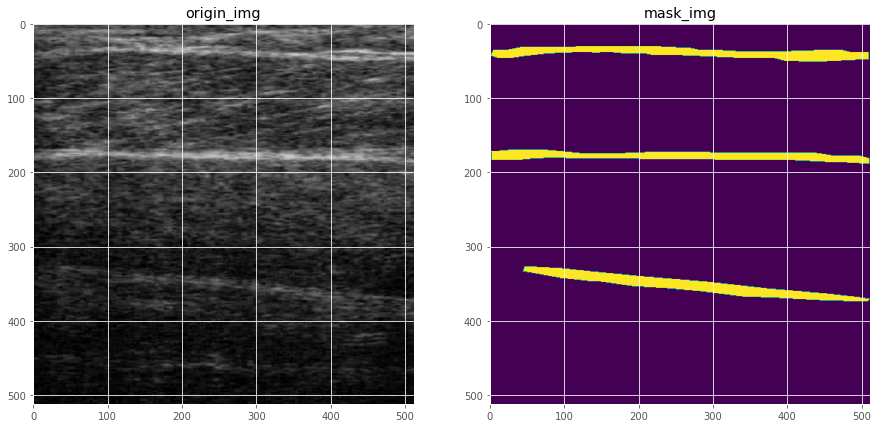

In [10]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = transforms.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

## 模型训练

In [11]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        num_classes = net.module.num_classes
    else:
        num_classes = net.num_classes
    criterion = nn.CrossEntropyLoss() if num_classes > 1 else nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)
            dice_score += criterion(mask_pred, mask_true.float())
            dice_score += dice_loss(mask_pred, mask_true)
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

In [12]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model, device, 
          project = 'U-Net',
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    
    if isinstance(model, nn.DataParallel):
        num_classes = model.module.num_classes
        input_channels = model.module.input_channels
    else:
        num_classes = model.num_classes
        input_channels = model.input_channels
        
    # (Initialize logging)
    experiment = wandb.init(project=project, resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')
    

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     optimizer = optim.SGD(params, lr=config['lr'], momentum=config['momentum'],
#                               nesterov=config['nesterov'], weight_decay=config['weight_decay'])

    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    
    criterion = nn.CrossEntropyLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary').cuda()
    
    global_step = 0
    

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == input_channels, \
                    f'Network has been defined with {input_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        model.train()
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
            


In [13]:
model = UNext_S(input_channels=3, num_classes=1, img_size=512)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(memory_format=torch.channels_last)
model.to(device)


total_params = sum(p.numel() for p in model.parameters())
print(f"U-Next-ScConv模型参数量为：{total_params}")
print("其详情为：")
for name,parameters in model.named_parameters():
    print(name,':',parameters.size())

train(model, device, project='U-Next-ScConv')


out_channels: 16 squeeze_radio:  2 up_channel:  4 in_ch (out_channels // squeeze_radio):  2 out_ch(out_channels): 16
out_channels: 16 squeeze_radio:  2 low_channel:  4 in_ch (low_channel // squeeze_radio):  2 out_ch(out_channels - low_channel // squeeze_radio): 14
out_channels: 32 squeeze_radio:  2 up_channel:  8 in_ch (out_channels // squeeze_radio):  4 out_ch(out_channels): 32
out_channels: 32 squeeze_radio:  2 low_channel:  8 in_ch (low_channel // squeeze_radio):  4 out_ch(out_channels - low_channel // squeeze_radio): 28
out_channels: 64 squeeze_radio:  2 up_channel:  64 in_ch (out_channels // squeeze_radio):  32 out_ch(out_channels): 64
out_channels: 64 squeeze_radio:  2 low_channel:  64 in_ch (low_channel // squeeze_radio):  32 out_ch(out_channels - low_channel // squeeze_radio): 32
out_channels: 32 squeeze_radio:  2 up_channel:  32 in_ch (out_channels // squeeze_radio):  16 out_ch(out_channels): 32
out_channels: 32 squeeze_radio:  2 low_channel:  32 in_ch (low_channel // squeeze_

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


Validation round: 100%|██████████| 115/115 [00:05<00:00, 22.54batch/s]


Validation dice loss: 3.4131510257720947, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:05<00:00, 22.12batch/s]


Validation dice loss: 3.4097955226898193, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:05<00:00, 22.06batch/s]


Validation dice loss: 3.4083261489868164, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:05<00:00, 21.64batch/s]


Validation dice loss: 3.4079649448394775, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:05<00:00, 22.77batch/s]


Validation dice loss: 3.406332015991211, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.77batch/s]


Validation dice loss: 3.405345916748047, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.07batch/s]


Validation dice loss: 3.4017930030822754, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.89batch/s]


Validation dice loss: 3.4026293754577637, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.26batch/s]


Validation dice loss: 3.4002861976623535, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.73batch/s]


Validation dice loss: 3.3971385955810547, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.75batch/s]


Validation dice loss: 3.3960390090942383, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.60batch/s]


Validation dice loss: 3.3958003520965576, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.84batch/s]


Validation dice loss: 3.3947131633758545, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.79batch/s]


Validation dice loss: 3.390850305557251, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.19batch/s]


Validation dice loss: 3.3938753604888916, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.69batch/s]


Validation dice loss: 3.3914694786071777, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.32batch/s]


Validation dice loss: 3.3896141052246094, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.60batch/s]


Validation dice loss: 3.3919477462768555, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.79batch/s]


Validation dice loss: 3.3845138549804688, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.16batch/s]


Validation dice loss: 3.3897931575775146, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.73batch/s]


Validation dice loss: 3.3797028064727783, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.15batch/s]


Validation dice loss: 3.3848323822021484, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.07batch/s]


Validation dice loss: 3.383690357208252, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.83batch/s]


Validation dice loss: 3.3849387168884277, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.56batch/s]


Validation dice loss: 3.3840267658233643, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.78batch/s]


Validation dice loss: 3.3826496601104736, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.62batch/s]


Validation dice loss: 3.380626678466797, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.64batch/s]


Validation dice loss: 3.370445489883423, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.80batch/s]


Validation dice loss: 3.3749899864196777, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.92batch/s]


Validation dice loss: 3.3744921684265137, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.54batch/s]


Validation dice loss: 3.37078595161438, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.54batch/s]


Validation dice loss: 3.3756394386291504, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.07batch/s]


Validation dice loss: 3.366149425506592, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.01batch/s]


Validation dice loss: 3.3676865100860596, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.97batch/s]


Validation dice loss: 3.367659330368042, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.44batch/s]


Validation dice loss: 3.36724853515625, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.79batch/s]


Validation dice loss: 3.364102602005005, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.55batch/s]


Validation dice loss: 3.361593723297119, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.08batch/s]


Validation dice loss: 3.350377321243286, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.67batch/s]


Validation dice loss: 3.348898410797119, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.25batch/s]


Validation dice loss: 3.3479716777801514, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.35batch/s]


Validation dice loss: 3.3325302600860596, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.14batch/s]


Validation dice loss: 3.3350698947906494, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.53batch/s]


Validation dice loss: 3.328792095184326, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.25batch/s]


Validation dice loss: 3.3436033725738525, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.91batch/s]


Validation dice loss: 3.337698459625244, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.86batch/s]


Validation dice loss: 3.3336100578308105, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.95batch/s]


Validation dice loss: 3.3381712436676025, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.98batch/s]


Validation dice loss: 3.3294479846954346, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.20batch/s]


Validation dice loss: 3.32368803024292, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.74batch/s]


Validation dice loss: 3.312943696975708, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.56batch/s]


Validation dice loss: 3.3256070613861084, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.30batch/s]


Validation dice loss: 3.2985923290252686, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.51batch/s]


Validation dice loss: 3.3308303356170654, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.09batch/s]


Validation dice loss: 3.3150417804718018, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.47batch/s]


Validation dice loss: 3.3183460235595703, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.76batch/s]


Validation dice loss: 3.288506507873535, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.98batch/s]


Validation dice loss: 3.288100481033325, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.09batch/s]


Validation dice loss: 3.303758382797241, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.06batch/s]


Validation dice loss: 3.3138046264648438, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.74batch/s]


Validation dice loss: 3.3056275844573975, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.07batch/s]


Validation dice loss: 3.2898871898651123, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.27batch/s]


Validation dice loss: 3.2859604358673096, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.17batch/s]


Validation dice loss: 3.2875146865844727, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.60batch/s]


Validation dice loss: 3.283390760421753, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.82batch/s]


Validation dice loss: 3.285397529602051, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.37batch/s]


Validation dice loss: 3.290468454360962, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.63batch/s]


Validation dice loss: 3.2838096618652344, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.34batch/s]


Validation dice loss: 3.2468466758728027, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.05batch/s]


Validation dice loss: 3.2931277751922607, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:05<00:00, 22.42batch/s]


Validation dice loss: 3.2645699977874756, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.17batch/s]


Validation dice loss: 3.2573864459991455, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.50batch/s]


Validation dice loss: 3.2687954902648926, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.20batch/s]


Validation dice loss: 3.2759244441986084, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.92batch/s]


Validation dice loss: 3.2380683422088623, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.85batch/s]


Validation dice loss: 3.254018545150757, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.14batch/s]


Validation dice loss: 3.2659425735473633, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.65batch/s]


Validation dice loss: 3.23311710357666, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.98batch/s]


Validation dice loss: 3.231440305709839, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.67batch/s]


Validation dice loss: 3.222792387008667, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.98batch/s]


Validation dice loss: 3.2391815185546875, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.59batch/s]


Validation dice loss: 3.198147773742676, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.48batch/s]


Validation dice loss: 3.223942995071411, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.46batch/s]


Validation dice loss: 3.227213144302368, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.78batch/s]


Validation dice loss: 3.2265100479125977, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.61batch/s]


Validation dice loss: 3.2140517234802246, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.75batch/s]


Validation dice loss: 3.234589099884033, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.23batch/s]


Validation dice loss: 3.2177133560180664, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.83batch/s]


Validation dice loss: 3.1822614669799805, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.02batch/s]


Validation dice loss: 3.1789746284484863, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.25batch/s]


Validation dice loss: 3.1662893295288086, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.04batch/s]


Validation dice loss: 3.1381940841674805, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.32batch/s]


Validation dice loss: 3.153937339782715, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.48batch/s]


Validation dice loss: 3.1638002395629883, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.38batch/s]


Validation dice loss: 3.1046340465545654, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.82batch/s]


Validation dice loss: 3.1474509239196777, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.01batch/s]


Validation dice loss: 3.142958641052246, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.50batch/s]


Validation dice loss: 3.205998182296753, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.26batch/s]


Validation dice loss: 3.1560757160186768, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.57batch/s]


Validation dice loss: 3.1720101833343506, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.99batch/s]


Validation dice loss: 3.074319362640381, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.05batch/s]


Validation dice loss: 3.103142738342285, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.08batch/s]


Validation dice loss: 3.05482816696167, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.28batch/s]


Validation dice loss: 3.1363351345062256, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.43batch/s]


Validation dice loss: 3.161024332046509, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.99batch/s]


Validation dice loss: 3.167090654373169, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.89batch/s]


Validation dice loss: 3.1526594161987305, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.06batch/s]


Validation dice loss: 3.0963120460510254, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.86batch/s]


Validation dice loss: 3.0659844875335693, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.17batch/s]


Validation dice loss: 3.0989327430725098, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.84batch/s]


Validation dice loss: 3.0930566787719727, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.97batch/s]


Validation dice loss: 3.0039539337158203, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.54batch/s]


Validation dice loss: 3.0433666706085205, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.80batch/s]


Validation dice loss: 3.0338916778564453, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.18batch/s]


Validation dice loss: 2.9322099685668945, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.22batch/s]


Validation dice loss: 2.9816930294036865, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.80batch/s]


Validation dice loss: 2.988604784011841, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.89batch/s]


Validation dice loss: 2.868093967437744, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.54batch/s]


Validation dice loss: 2.803115129470825, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.21batch/s]


Validation dice loss: 2.8728861808776855, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.87batch/s]


Validation dice loss: 2.8294479846954346, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.78batch/s]


Validation dice loss: 2.7809436321258545, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.40batch/s]


Validation dice loss: 2.6344292163848877, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.35batch/s]


Validation dice loss: 2.682313919067383, IoU Score 0.0011948624160140753


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.08batch/s]


Validation dice loss: 2.5968644618988037, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.89batch/s]


Validation dice loss: 2.553602457046509, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.12batch/s]


Validation dice loss: 2.701678514480591, IoU Score 0.004982152953743935


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.87batch/s]


Validation dice loss: 2.4989371299743652, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.59batch/s]


Validation dice loss: 2.553542375564575, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.90batch/s]


Validation dice loss: 2.4879262447357178, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.67batch/s]


Validation dice loss: 2.4375267028808594, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.47batch/s]


Validation dice loss: 2.3563807010650635, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.35batch/s]


Validation dice loss: 2.3917837142944336, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.29batch/s]


Validation dice loss: 2.236680269241333, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.89batch/s]


Validation dice loss: 2.318497896194458, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:05<00:00, 22.56batch/s]


Validation dice loss: 2.3343825340270996, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.70batch/s]


Validation dice loss: 2.3117966651916504, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.86batch/s]


Validation dice loss: 2.2992000579833984, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.40batch/s]


Validation dice loss: 2.2789196968078613, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.77batch/s]


Validation dice loss: 2.152531385421753, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.56batch/s]


Validation dice loss: 2.2965474128723145, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.63batch/s]


Validation dice loss: 2.2778496742248535, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.24batch/s]


Validation dice loss: 2.2351365089416504, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.89batch/s]


Validation dice loss: 2.1349713802337646, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.87batch/s]


Validation dice loss: 2.1687204837799072, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.40batch/s]


Validation dice loss: 2.237358808517456, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.31batch/s]


Validation dice loss: 2.1773672103881836, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.83batch/s]


Validation dice loss: 2.242888927459717, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.31batch/s]


Validation dice loss: 2.227987766265869, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.18batch/s]


Validation dice loss: 2.158287286758423, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.89batch/s]


Validation dice loss: 2.1906235218048096, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.04batch/s]


Validation dice loss: 2.2362661361694336, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.66batch/s]


Validation dice loss: 2.3563551902770996, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:05<00:00, 22.31batch/s]


Validation dice loss: 2.2443511486053467, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.09batch/s]


Validation dice loss: 2.0539894104003906, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.31batch/s]


Validation dice loss: 2.1010496616363525, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.58batch/s]


Validation dice loss: 2.1042232513427734, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.57batch/s]


Validation dice loss: 2.061206340789795, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.15batch/s]


Validation dice loss: 2.130673885345459, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.15batch/s]


Validation dice loss: 1.9830543994903564, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.76batch/s]


Validation dice loss: 1.998278021812439, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.12batch/s]


Validation dice loss: 2.148653745651245, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.94batch/s]


Validation dice loss: 2.0811715126037598, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.59batch/s]


Validation dice loss: 2.0583183765411377, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.28batch/s]


Validation dice loss: 2.0113847255706787, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.34batch/s]


Validation dice loss: 2.2905380725860596, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.06batch/s]


Validation dice loss: 2.0318500995635986, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.08batch/s]


Validation dice loss: 2.049367904663086, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.98batch/s]


Validation dice loss: 1.9201695919036865, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.32batch/s]


Validation dice loss: 2.09354829788208, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.57batch/s]


Validation dice loss: 2.041358470916748, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.54batch/s]


Validation dice loss: 2.0838117599487305, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.44batch/s]


Validation dice loss: 2.135326623916626, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.40batch/s]


Validation dice loss: 2.006878137588501, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.11batch/s]


Validation dice loss: 1.9062657356262207, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.55batch/s]


Validation dice loss: 2.3310887813568115, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.03batch/s]


Validation dice loss: 1.8016260862350464, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.78batch/s]


Validation dice loss: 1.8936406373977661, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.79batch/s]


Validation dice loss: 2.03800630569458, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.98batch/s]


Validation dice loss: 2.0554006099700928, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.20batch/s]


Validation dice loss: 1.9614899158477783, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.99batch/s]


Validation dice loss: 2.1053056716918945, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.51batch/s]


Validation dice loss: 2.1750874519348145, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.68batch/s]


Validation dice loss: 1.869922399520874, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.54batch/s]


Validation dice loss: 1.7513853311538696, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.49batch/s]


Validation dice loss: 1.9106850624084473, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.41batch/s]


Validation dice loss: 1.8062496185302734, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.29batch/s]


Validation dice loss: 1.8083436489105225, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.66batch/s]


Validation dice loss: 1.7552534341812134, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.38batch/s]


Validation dice loss: 1.9846147298812866, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.41batch/s]


Validation dice loss: 1.6512197256088257, IoU Score 0.0005247154622338712


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.16batch/s]


Validation dice loss: 1.752655267715454, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.37batch/s]


Validation dice loss: 1.7233917713165283, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.39batch/s]


Validation dice loss: 1.7200425863265991, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.20batch/s]


Validation dice loss: 1.6871222257614136, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.40batch/s]


Validation dice loss: 1.6887134313583374, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.13batch/s]


Validation dice loss: 1.6952836513519287, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.77batch/s]


Validation dice loss: 1.6019105911254883, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.39batch/s]


Validation dice loss: 1.6729705333709717, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.06batch/s]


Validation dice loss: 1.7936688661575317, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.45batch/s]


Validation dice loss: 1.4980409145355225, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.44batch/s]


Validation dice loss: 1.700447916984558, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.49batch/s]


Validation dice loss: 1.7107629776000977, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.33batch/s]


Validation dice loss: 1.5378433465957642, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.08batch/s]


Validation dice loss: 1.5904384851455688, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.20batch/s]


Validation dice loss: 1.5054820775985718, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.87batch/s]


Validation dice loss: 1.5777329206466675, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.32batch/s]


Validation dice loss: 1.5060901641845703, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.11batch/s]


Validation dice loss: 1.6458015441894531, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.30batch/s]


Validation dice loss: 1.6120185852050781, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.21batch/s]


Validation dice loss: 1.5013988018035889, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.03batch/s]


Validation dice loss: 1.539914846420288, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.10batch/s]


Validation dice loss: 1.5748847723007202, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.85batch/s]


Validation dice loss: 1.4653772115707397, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.17batch/s]


Validation dice loss: 1.6283420324325562, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.60batch/s]


Validation dice loss: 1.5380611419677734, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.09batch/s]


Validation dice loss: 1.7343778610229492, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.01batch/s]


Validation dice loss: 1.551971197128296, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.19batch/s]


Validation dice loss: 1.5508854389190674, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.29batch/s]


Validation dice loss: 1.5421704053878784, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.55batch/s]


Validation dice loss: 1.6357033252716064, IoU Score 0.0003447336202953011


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.66batch/s]


Validation dice loss: 2.0932984352111816, IoU Score 0.00024445640156045556


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.68batch/s]


Validation dice loss: 1.5307128429412842, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.06batch/s]


Validation dice loss: 1.453669786453247, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.02batch/s]


Validation dice loss: 1.6685856580734253, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.59batch/s]


Validation dice loss: 1.613526463508606, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.32batch/s]


Validation dice loss: 1.5252759456634521, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.39batch/s]


Validation dice loss: 1.5875509977340698, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.25batch/s]


Validation dice loss: 1.5707522630691528, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.28batch/s]


Validation dice loss: 1.6780591011047363, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.86batch/s]


Validation dice loss: 1.8225972652435303, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.11batch/s]


Validation dice loss: 1.7073748111724854, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.15batch/s]


Validation dice loss: 1.5976449251174927, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.94batch/s]


Validation dice loss: 1.6796975135803223, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.20batch/s]


Validation dice loss: 1.6281853914260864, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.30batch/s]


Validation dice loss: 1.8537397384643555, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.26batch/s]


Validation dice loss: 1.6568388938903809, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.84batch/s]


Validation dice loss: 1.7310258150100708, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.42batch/s]


Validation dice loss: 1.6123818159103394, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.17batch/s]


Validation dice loss: 1.6489137411117554, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.04batch/s]


Validation dice loss: 1.553236961364746, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.11batch/s]


Validation dice loss: 1.9155296087265015, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.92batch/s]


Validation dice loss: 1.5551331043243408, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.13batch/s]


Validation dice loss: 1.601010799407959, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.12batch/s]


Validation dice loss: 1.9410690069198608, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.00batch/s]


Validation dice loss: 1.671658992767334, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.90batch/s]


Validation dice loss: 1.6696385145187378, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.65batch/s]


Validation dice loss: 1.4241060018539429, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.36batch/s]


Validation dice loss: 1.8024874925613403, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.37batch/s]


Validation dice loss: 1.4538514614105225, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.17batch/s]


Validation dice loss: 1.6344900131225586, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.09batch/s]


Validation dice loss: 1.5467662811279297, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.20batch/s]


Validation dice loss: 1.4145588874816895, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.91batch/s]


Validation dice loss: 1.4756413698196411, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.47batch/s]


Validation dice loss: 1.4545716047286987, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.43batch/s]


Validation dice loss: 1.8894575834274292, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.20batch/s]


Validation dice loss: 1.5801622867584229, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.39batch/s]


Validation dice loss: 1.9307045936584473, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.49batch/s]


Validation dice loss: 1.6791529655456543, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.54batch/s]


Validation dice loss: 1.4542477130889893, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.84batch/s]


Validation dice loss: 1.6413183212280273, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.88batch/s]


Validation dice loss: 1.9450303316116333, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.12batch/s]


Validation dice loss: 1.9542492628097534, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.20batch/s]


Validation dice loss: 1.489375352859497, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.29batch/s]


Validation dice loss: 1.520039677619934, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.20batch/s]


Validation dice loss: 1.7282713651657104, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.99batch/s]


Validation dice loss: 1.8604108095169067, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.50batch/s]


Validation dice loss: 1.8223828077316284, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.97batch/s]


Validation dice loss: 1.546717643737793, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.02batch/s]


Validation dice loss: 1.660075068473816, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.86batch/s]


Validation dice loss: 1.4419747591018677, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.32batch/s]


Validation dice loss: 1.5781124830245972, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.77batch/s]


Validation dice loss: 1.8247345685958862, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.02batch/s]


Validation dice loss: 2.0223770141601562, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.84batch/s]


Validation dice loss: 1.465085744857788, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.83batch/s]


Validation dice loss: 1.5057111978530884, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.34batch/s]


Validation dice loss: 1.6568400859832764, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.44batch/s]


Validation dice loss: 2.14863920211792, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.79batch/s]


Validation dice loss: 1.705467700958252, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.83batch/s]


Validation dice loss: 1.6350780725479126, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.11batch/s]


Validation dice loss: 1.5260062217712402, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.39batch/s]


Validation dice loss: 1.5178760290145874, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.44batch/s]


Validation dice loss: 1.9795396327972412, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.61batch/s]


Validation dice loss: 1.5566997528076172, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.64batch/s]


Validation dice loss: 2.0489420890808105, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.09batch/s]


Validation dice loss: 1.5792567729949951, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.86batch/s]


Validation dice loss: 1.6616276502609253, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.29batch/s]


Validation dice loss: 1.516297698020935, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.67batch/s]


Validation dice loss: 1.9419702291488647, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.42batch/s]


Validation dice loss: 1.6417973041534424, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.24batch/s]


Validation dice loss: 1.8252891302108765, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.33batch/s]


Validation dice loss: 1.6073144674301147, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.01batch/s]


Validation dice loss: 1.5627329349517822, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 23.89batch/s]


Validation dice loss: 1.7276725769042969, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.58batch/s]


Validation dice loss: 2.2950685024261475, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.83batch/s]


Validation dice loss: 1.6919312477111816, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.41batch/s]


Validation dice loss: 1.8551961183547974, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.21batch/s]


Validation dice loss: 1.4355865716934204, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.44batch/s]


Validation dice loss: 1.7115349769592285, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.68batch/s]


Validation dice loss: 1.6791912317276, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.20batch/s]


Validation dice loss: 2.094125986099243, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.08batch/s]


Validation dice loss: 1.3826709985733032, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 25.18batch/s]


Validation dice loss: 1.8162143230438232, IoU Score 0.0


Validation round: 100%|██████████| 115/115 [00:04<00:00, 24.10batch/s]


Validation dice loss: 1.6014834642410278, IoU Score 0.0


Epoch 60/60: 100%|██████████| 456/456 [01:00<00:00,  7.51img/s, loss (batch)=0.445]
